In [1]:
import os
import sys
import importlib
import numpy as np
import torch as pt
import pandas as pd
import mdtraj as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from matplotlib import rcParams

import src as sp
import runtime as rt
import mdtraj_utils as mdu
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14

In [2]:
# parameters
device = pt.device("cuda")

# model parameters
# r6
save_path = "model/save/s_v6_4_2022-09-16_11-51"  # virtual Cb & partial
#save_path = "model/save/s_v6_5_2022-09-16_11-52"  # virtual Cb, partial & noise

# r7
#save_path = "model/save/s_v7_0_2023-04-25"  # partial chain
#save_path = "model/save/s_v7_1_2023-04-25"  # partial secondary structure
#save_path = "model/save/s_v7_2_2023-04-25"  # partial chain high coverage

# create models
model = rt.SequenceModel(save_path, "model.pt", device=device)

# create confidence mapping
conf = rt.ConfidenceMap("../results/{}_cdf.csv".format(os.path.basename(save_path)))

In [3]:
# load trajectory
traj = md.load("examples/tem1_swish1_traj0.xtc", top="examples/tem1_swish1.gro")

/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (HIE, HIS)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PRO, HIS)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLU, PRO)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/khaos/miniconda3/envs/carbonara/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (THR, GLU)
 

In [4]:
# parameters
n_skip = 10

# convert trajectory to structure 
structure = rt.traj_to_struct(traj)

# skips frames
structure['xyz'] = structure['xyz'][:,::n_skip]

# apply model on full structure
_, P, y = model(structure)

In [5]:
si, ss, c = [], [], []
seq_ref = rt.max_pred_to_seq(y)
for i in range(P.shape[0]):
    seq = rt.max_pred_to_seq(P[i])
    si.append(rt.sequence_identity(seq_ref, seq))
    ss.append(rt.sequence_similarity(seq_ref, seq))
    c.append(np.mean(np.max(conf(P[i].numpy()), axis=1)))
    
si = np.array(si)
ss = np.array(ss)
c = np.array(c)

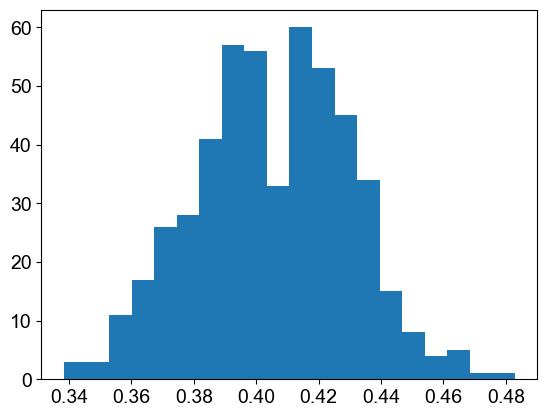

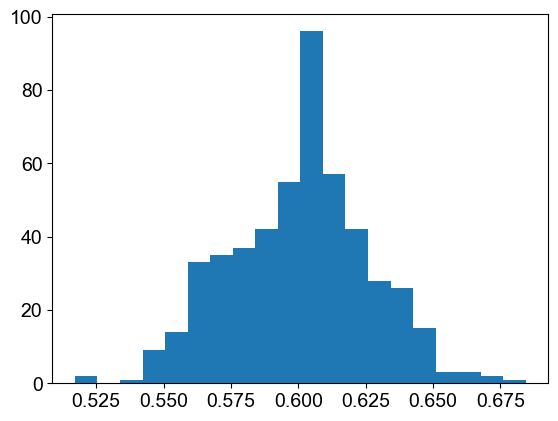

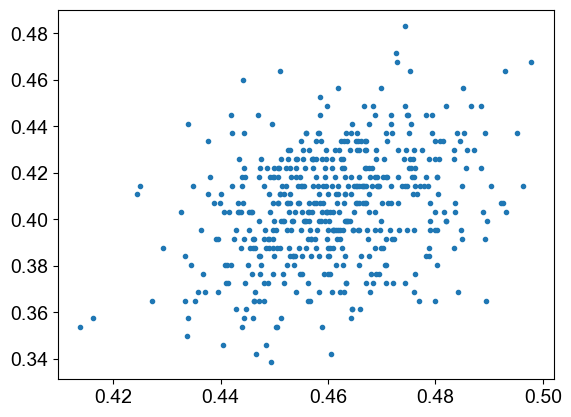

In [6]:
plt.figure()
plt.hist(si, bins=20)
plt.show()

plt.figure()
plt.hist(ss, bins=20)
plt.show()

plt.figure()
plt.plot(c, si, '.')
plt.show()

In [7]:
np.mean(si), np.mean(ss)

(0.4052579252142104, 0.6003430401554306)

In [8]:
np.median(si), np.median(ss)

(0.4068441064638783, 0.6007604562737643)

In [9]:
pc = pt.mean(P, dim=0)
cc = np.mean(np.max(conf(pc.numpy()), axis=1))
seqc = rt.max_pred_to_seq(pc)
sic = rt.sequence_identity(seq_ref, seqc)
ssc = rt.sequence_similarity(seq_ref, seqc)
sic, ssc, cc

(0.5475285171102662, 0.7338403041825095, 0.2963312251670557)

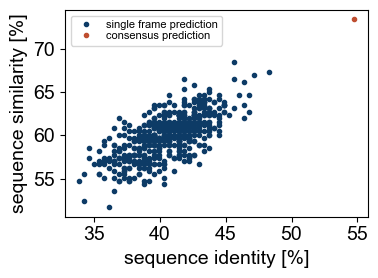

In [10]:
plt.figure(figsize=(4,3))
plt.plot(1e2*si, 1e2*ss, '.', label='single frame prediction', color=colors[1])
plt.plot(1e2*sic, 1e2*ssc, '.', label='consensus prediction', color=colors[0])
plt.xlabel('sequence identity [%]')
plt.ylabel('sequence similarity [%]')
plt.legend(loc='best', prop={'size': 8}, labelspacing=0.1)
plt.tight_layout()
plt.savefig("graphs/tem1_swish1.svg")
plt.show()